In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import sys
import os.path
import pytesseract

class OCRError(Exception):
    pass


def get_contours(img):
    # img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #edges = cv2.Canny(img, 20, 60)
    # print('edges:', edges)
    rimg = ~img
    ret, thr = cv2.threshold(rimg, 200, 250, 0)
    contours,_ = cv2.findContours(thr, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # images, contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_LIST)
    return filter_(contours)


def filter_(contours):
    contours_dict = dict()
    for cont in contours:
        x, y, w, h = cv2.boundingRect(cont)
        area = cv2.contourArea(cont)
        if 10 < area and 10 < w and h > 5:
            contours_dict[(x, y, w, h)] = cont
    return sorted(contours_dict.values(), key=cv2.boundingRect)


def to_contours_image(contours, ref_image):
    blank_background = np.zeros_like(ref_image)
    img_contours = cv2.drawContours(blank_background, contours, -1, (255, 255, 255), thickness=2)
    return img_contours


def is_overlapping_horizontally(box1, box2):
    x1, _, w1, _ = box1
    x2, _, _, _ = box2
    if x1 > x2:
        return is_overlapping_horizontally(box2, box1)
    return (x2 - x1) < w1


def merge(box1, box2):
    assert is_overlapping_horizontally(box1, box2)
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    x = min(x1, x2)
    w = max(x1 + w1, x2 + w2) - x
    y = min(y1, y2)
    h = max(y1 + h1, y2 + h2) - y
    return x, y, w, h


In [2]:
def get_windows(contours):
    """return List[Tuple[x: Int, y: Int, w: Int, h: Int]]"""
    boxes = []
    for cont in contours:
        box = cv2.boundingRect(cont)
        if not boxes:
            boxes.append(box)
        else:
            if is_overlapping_horizontally(boxes[-1], box):
                last_box = boxes.pop()
                merged_box = merge(box, last_box)
                boxes.append(merged_box)
            else:
                boxes.append(box)
    return boxes


def to_digit_images(img):
    contours = get_contours(img)
    image_contours = to_contours_image(contours, img)

    windows = get_windows(contours)
    img2 = img.copy()
    for box in windows:
        x, y, w, h = box
        img2 = cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.imshow(img2)
    plt.show()
    if len(windows) != 4:
        raise OCRError
        return []
    else:
        xs = [image_contours[y:y+h, x:x+w] for (x, y, w, h) in windows]
        xs = [img[y:y+h, x:x+w] for (x, y, w, h) in windows]
        return xs


shape= (480, 800)
call pytesseract
image= 


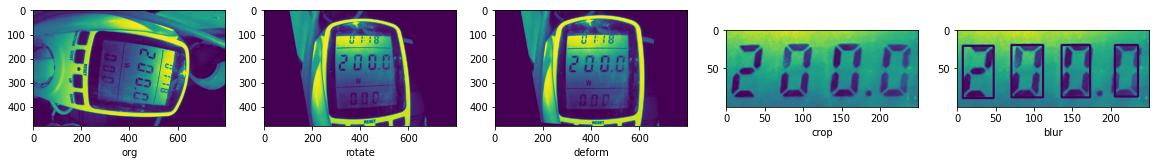

c:\users\ekyuh\p3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 12 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\ekyuh\p3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 12 missing from current font.
  font.set_text(s, 0, flags=flags)


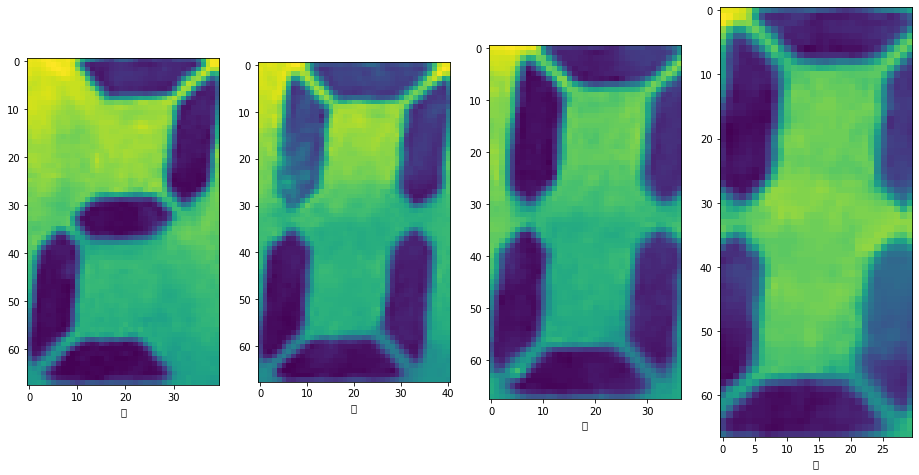

In [3]:
def conv(img, n):
    #print('conv',n)
    kernel = np.ones((n,n),np.float32)/(n*n)
    return cv2.filter2D(img, -1, kernel)

def blur(img, method):
    if method == "blur": return cv2.blur(img,(7,7))
    if method == "median": return cv2.medianBlur(img,9)
    if method == "bilateral": return cv2.bilateralFilter(img,9,75,75)
    if method == "gaussian": return cv2.GaussianBlur(img,(5,5),8)

def file2files(fpath):
    plt.figure(figsize=(20,20))
    img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
    plt.subplot(1,5,1)
    plt.imshow(img)
    plt.xlabel('org')
    print('shape=', img.shape)
    M = cv2.getRotationMatrix2D((417, 261), 100, 1.0)
    img = cv2.warpAffine(img, M, (800, 480))
    
    plt.subplot(1,5,2)
    plt.imshow(img)
    plt.xlabel('rotate')
    cv2.imwrite('x.jpg', img)
    
    #if valvegod
    #ts1 = np.float32([[138,432],[167,521],[708,407],[709,517]])
    #ts2 = np.float32([[140,430],[140,520],[706,430],[706,520]])
    #if power meter
    pts1 = np.float32([[289,106],[304,407],[525,110],[551,392]])
    pts2 = np.float32([[290,105],[297,407],[551,105],[551,407]])
    M = cv2.getPerspectiveTransform(pts1, pts2)
    img = cv2.warpPerspective(img, M, (800, 480))
    plt.subplot(1,5,3)
    plt.imshow(img)
    plt.xlabel('deform')
    cv2.imwrite('y.jpg', img)
    
    img = img[170:270,300:550]
    plt.subplot(1,5,4)
    plt.imshow(img)
    plt.xlabel('crop')
    
    print("call pytesseract")
    n = pytesseract.image_to_string(img, config='--oem 3 --psm 10 -c tessedit_char_whitelist=0123456789')
    print("image=",n)

    #img = blur(conv(img,3), "gaussian")
    plt.subplot(1,5,5)
    plt.imshow(img)
    plt.xlabel('blur')

    rois = to_digit_images(img)
    plt.figure(figsize=(20,20))
    for i, digit_img in enumerate(rois):
        #outfilepath = fpath.with_name(fpath.stem + ('_%d' % i) + '.png')
        #cv2.imwrite(outfilepath.as_posix(), digit_img)
        #rd = ~digit_img
        rd = digit_img
        plt.subplot(1,5,i+1)
        plt.imshow(rd)
        n = pytesseract.image_to_string(rd, config='--oem 3 --psm 10 -c tessedit_char_whitelist=0123456789')
        print(n)
        plt.xlabel(str(n))
    plt.show()

file = '0003.jpg'
if not os.path.isfile(file): 
    print('nofile', file)
else:
    file2files(file)